# Load Libraries, Modules, and Magics

In [97]:
import re
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import random
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
import xgboost as xgb
import operator
from scipy.stats import uniform as sp_rand
from scipy.stats import randint as sp_randint
import scipy.stats as st
from scipy.stats.mstats import mode
from matplotlib import pyplot as plt
import seaborn as sns
import time
import math
import datetime
import random
from yellowbrick.features import ParallelCoordinates, Rank2D, JointPlotVisualizer
from yellowbrick.regressor import ResidualsPlot, AlphaSelection, PredictionError

%matplotlib inline

# Load (fixed) Data files

In [98]:
train_orig = pd.read_csv('./assets/train.csv', header=0)
test_orig = pd.read_csv('./assets/test.csv', header=0)
severity_type = pd.read_csv('./assets/severity_type.csv', header=0)
log_feature = pd.read_csv('./assets/log_feature.csv', header=0)
event_type = pd.read_csv('./assets/event_type_fixed.csv', header=0)
resource_type = pd.read_csv('./assets/resource_type.csv', header=0)

# Functions That Make EDA Easier

In [99]:
def norm_rows(df):
    with np.errstate(invalid='ignore'):
        return df.div(df.sum(axis=1), axis=0).fillna(0)

In [100]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [101]:
def print_value_counts(input_df,col_name,is_normalized=False):
    for value in input_df[col_name].unique():
        print(value)
        print(input_df.loc[input_df[col_name] == value].fault_severity.value_counts(normalize=is_normalized))

In [102]:
def print_value_counts_spec(input_df,col_name,col_value,is_normalized=False):
    print(col_value)
    print(input_df.loc[input_df[col_name] == col_value].fault_severity.value_counts(normalize=is_normalized))

In [103]:
def convert_strings_to_ints(input_df,col_name,output_col_name):
    labels, levels = pd.factorize(input_df[col_name])
    input_df[output_col_name] = labels
    output_dict = dict(zip(input_df[col_name],input_df[output_col_name]))
    return (output_dict,input_df)

In [104]:
#assumes row normalized, doesn't do eps thing
def get_log_loss_row(row):
    ans = row['fault_severity']
    if (ans == 0):
        return -1.0 * np.log(row['predict_0'])
    elif (ans == 1):
        return -1.0 * np.log(row['predict_1'])
    elif (ans == 2):
        return -1.0 * np.log(row['predict_2'])
    else:
        print('not_acceptable_value')
        raise ValueError('Not of correct class')
        return -1000

In [105]:
def get_log_loss_row_two_classes(row):
    ans = row['fault_severity']
    if (ans == 0):
        return -1.0 * np.log(row['predict_low'])
    elif (ans == 1):
        return -1.0 * np.log(row['predict_high'])
    else:
        print('not_acceptable_value')
        raise ValueError('Not of correct class')
        return -1000

# EDA

In [106]:
pdp.ProfileReport(train_orig)

Number of variables,3
Number of observations,7381
Total Missing (%),0.0%
Total size in memory,173.1 KiB
Average record size in memory,24.0 B
Numeric,2
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [107]:
pdp.ProfileReport(test_orig)

Number of variables,2
Number of observations,11171
Total Missing (%),0.0%
Total size in memory,174.6 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [108]:
pdp.ProfileReport(severity_type)

Number of variables,2
Number of observations,18552
Total Missing (%),0.0%
Total size in memory,290.0 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [109]:
pdp.ProfileReport(log_feature)

Number of variables,3
Number of observations,58671
Total Missing (%),0.0%
Total size in memory,1.3 MiB
Average record size in memory,24.0 B
Numeric,2
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [110]:
pdp.ProfileReport(resource_type)

Number of variables,2
Number of observations,21076
Total Missing (%),0.0%
Total size in memory,329.4 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [111]:
pdp.ProfileReport(event_type)

Number of variables,2
Number of observations,34083
Total Missing (%),0.0%
Total size in memory,532.6 KiB
Average record size in memory,16.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## Analysis:
The data files present multiple views into linked data tables. Based on cardinality, my educated guess is that the ID field  is the key between the tables, with location and log_feature containing relevant outage data. The objective is to predict Telstra network's fault severity at a particular location based on the log data. Each observation in the main dataset (train.csv, test.csv) represents a location and point in time. They are identified by the "id" column, which is the key "id" used in other data files. Fault severity has 3 categories: 0,1,2. The observation of “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv). Also, the observations have been pre-split into train and test sets, but let's verify that was done without bias.

# Feature Engineering

### 1. Join all tables (on ID) into one monolithic file to prepare for modeling
### 2. Verify that files were separated without bias
### 3. Create features where necessary, especially with low incidence observations
### 4. Use preprocessing column to record outcome of each row (NaNs, new features, etc.), and pivot to make clean break
### 5. Use mode of severity to indicate relative severity of element types

In [112]:
df = pd.concat([train_orig,test_orig], ignore_index=True)
df.head()

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,fault_severity,id,location
0,1.0,14121,location 118
1,0.0,9320,location 91
2,1.0,14394,location 152
3,1.0,8218,location 931
4,0.0,14804,location 120


In [113]:
df.shape

(18552, 3)

In [114]:
# Let's get a look at the breakdown of fault_severity, since this will be our target vector
df.fault_severity.value_counts()

0.0    4784
1.0    1871
2.0     726
Name: fault_severity, dtype: int64

## Before we go any further, let's make our first quick model, evaluate, predict, and score

In [115]:
# Assign train and test sets, then encode the target vector with OneHotEncoder so we have three categories.
train = train_orig
test = test_orig
num_train_data = train.shape[0]
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(train[['fault_severity']].as_matrix())

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [116]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [117]:
y[:5]

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.]])

In [118]:
# Now, prepare and combine the data sets, and get only the integers from 'location'
train_test = train.drop(['fault_severity'],axis=1)
train_test = train_test.append(test,ignore_index=True)
train_test['location'] = train_test.location.map(lambda x: re.findall(r'\d+',x)[0])

In [119]:
train_test.head()

,id,location
0,14121,118
1,9320,91
2,14394,152
3,8218,931
4,14804,120


In [120]:
# Next, join all the other data tables, on 'id', and get only the integers from the data columns
data = event_type.merge(resource_type, on = 'id', how = 'inner')
data = data.merge(severity_type, on = 'id', how = 'inner')
data = data.merge(log_feature, on = 'id', how = 'inner')
data['severity_type'] = data.severity_type.map(lambda x: re.findall(r'\d+',x)[0])
data['log_feature'] = data.log_feature.map(lambda x: re.findall(r'\d+',x)[0])
data['event_type'] = data.event_type.map(lambda x: re.findall(r'\d+',x)[0])
data['resource_type'] = data.resource_type.map(lambda x: re.findall(r'\d+',x)[0])

In [121]:
data.head()

,id,event_type,resource_type,severity_type,log_feature,volume
0,6597.0,11,8,2,68,6
1,8011.0,15,8,2,68,7
2,2597.0,15,8,2,68,1
3,5022.0,15,8,1,172,2
4,5022.0,15,8,1,56,1


In [122]:
data.shape

(159129, 6)

In [123]:
# Now let's create that monolithic dataframe
all_data = pd.merge(train_test, data, on='id', how='inner')
all_data.head(10)

,id,location,event_type,resource_type,severity_type,log_feature,volume
0,14121,118,34,2,2,312,19
1,14121,118,34,2,2,232,19
2,14121,118,35,2,2,312,19
3,14121,118,35,2,2,232,19
4,9320,91,34,2,2,315,200
5,9320,91,34,2,2,235,116
6,9320,91,35,2,2,315,200
7,9320,91,35,2,2,235,116
8,9320,91,34,2,2,315,200
9,9320,91,34,2,2,235,116


## Different types of features can be extracted from the log files and other sources. All above features are categorical except for "volume".

### Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). It should not be confused with fault_severity (our target variable). 


In [124]:
# Create the features dataframe, using the encoded monolithic categorical features, then add volume
feature_name = ['location', 'event_type', 'resource_type', 'severity_type', 'log_feature']
enc = OneHotEncoder(n_values=np.array([1127, 55, 11, 6, 387]), sparse=False)
features = all_data['id']
features = pd.concat([features, pd.DataFrame(data=enc.fit_transform(all_data[feature_name].as_matrix()))], axis=1)
features = features.astype(int)
features['vol'] = all_data['volume']
feature_name.append('volume')
features = features.groupby(['id'],sort=False, as_index=False).sum()
features.head() 

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


,id,0,1,2,3,4,5,6,7,8,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
0,14121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,76
1,9320,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1264
2,14394,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,8218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,88
4,14804,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,96


### Wow, 1588 features. Let's see what we can do to focus on the low hanging fruit, and reduce overfitting. We'll use cross correlation to evaluate our top correlated features. 

In [125]:
# Create the Pearson cross correlation matrix
features_norm = (features - features.mean()) / (features.max() - features.min())
cross_corr = features_norm[:num_train_data].drop(['id'],axis=1)
cross_corr['y0'] = y[:,0]
cross_corr['y1'] = y[:,1]
cross_corr['y2'] = y[:,2]
cross_corr = cross_corr.corr().fillna(0)
cross_corr = cross_corr[['y0', 'y1', 'y2']].drop(['y0', 'y1', 'y2'])
cross_corr.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
y0,0.0,-0.013146,-0.023841,0.011507,-0.022345,0.008577,-0.015799,-0.004467,0.000210,0.036367,...,-0.019253,-1.762242e-15,-0.015799,-1.762242e-15,-1.762242e-15,-0.020538,0.008577,-1.762242e-15,-1.762242e-15,0.025226
y1,0.0,0.015727,0.031237,-0.009101,0.028252,-0.006783,0.019976,-0.015486,0.005416,-0.028763,...,0.007540,-3.890519e-16,-0.006783,-3.890519e-16,-3.890519e-16,-0.008818,-0.006783,-3.890519e-16,-3.890519e-16,-0.097786
y2,0.0,-0.001892,-0.007398,-0.005159,-0.005438,-0.003845,-0.003845,0.029784,-0.008248,-0.016303,...,0.019859,-4.430143e-16,0.035243,-4.430143e-16,-4.430143e-16,0.045814,-0.003845,-4.430143e-16,-4.430143e-16,0.102388


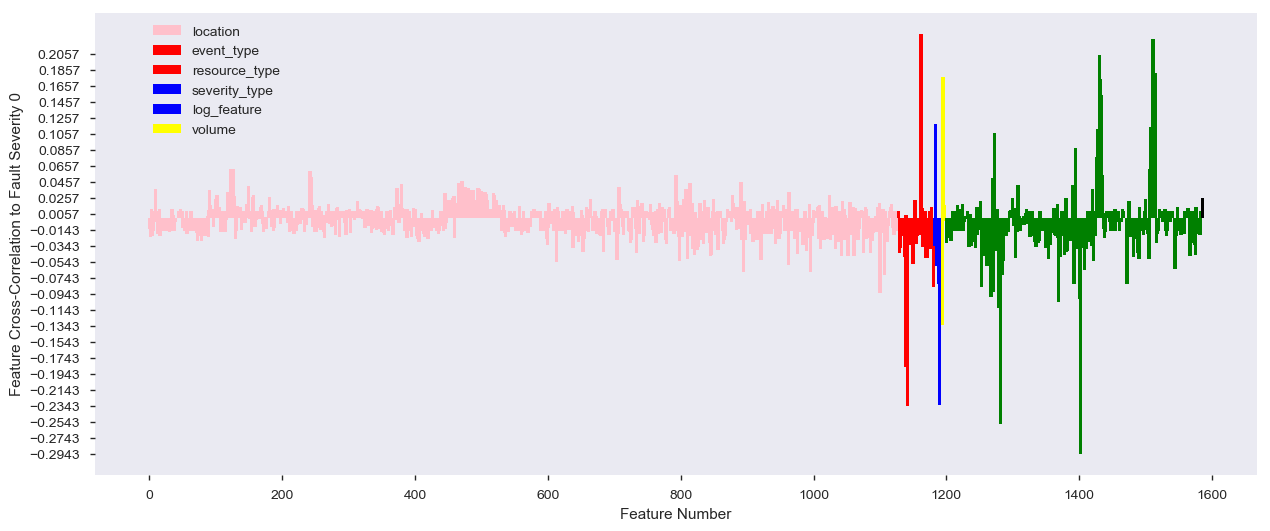

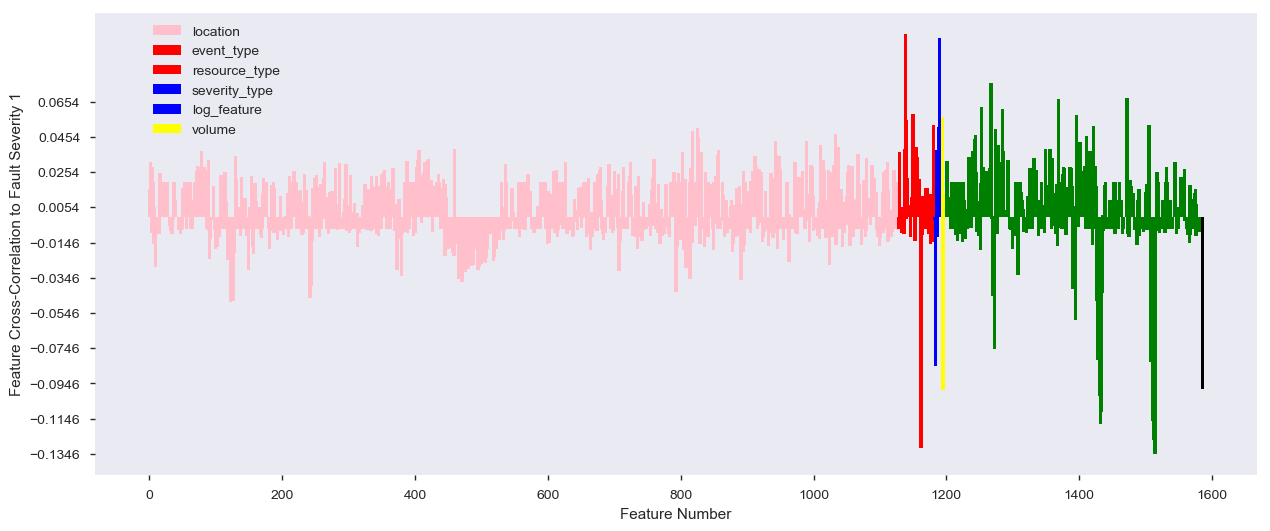

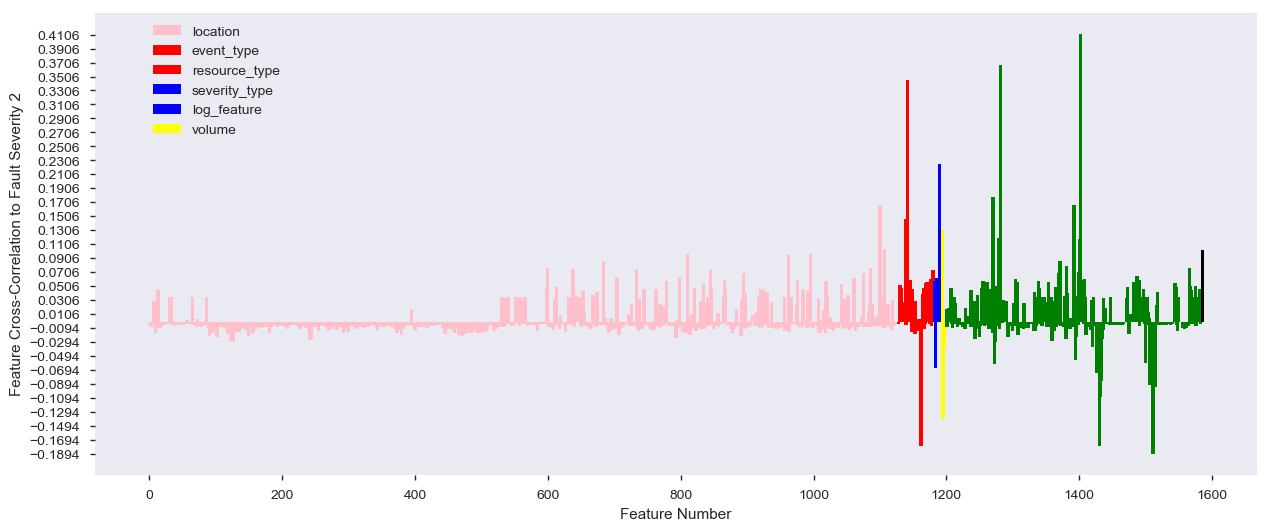

In [126]:
# now let's visualize that correlation matrix
clr = ['pink', 'red', 'blue', 'yellow', 'green', 'black']

for idx_corr in range(3):
    Y_corr = cross_corr.iloc[:,idx_corr]
    plt.figure(figsize=(15,6))
    for idx, n_featuer in enumerate(enc.n_values):
        xx = np.arange(enc.feature_indices_[idx], enc.feature_indices_[idx+1])
        yy = Y_corr[xx]
        plt.bar(xx, yy, width=5, color=clr[idx])
        plt.bar(1586,Y_corr[1586], width=5, color=clr[idx+1])
        plt.xlabel('Feature Number')
        plt.ylabel('Feature Cross-Correlation to Fault Severity '+str(idx_corr))
        plt.yticks(np.arange(min(yy), max(yy), 0.02))
        plt.grid(which='both', axis='both') 
        plt.legend(feature_name, bbox_to_anchor=(0.17, 1))    

In [127]:
# Choose a cross correlation threshold that will give us good signal without a lot of overfitting
cct = 0.05

In [130]:
# Finally! let's hit that XGB classifier syrup, with the buttery grid search, cross validated goodness.
# We'll also need to run it for each target variable
for idx in range (3):
    X = features_norm[:num_train_data].drop(['id'],axis=1).as_matrix()
    X = X[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    xgbc = xgb.XGBClassifier()
    clf1 = GridSearchCV(xgbc, {'max_depth': [4, 5,], 
                            'n_estimators': [100, 200], 
                            'learning_rate': [0.1, 0.01], 
                            'subsample': [1], 
                             }, 
                             verbose=1, n_jobs=3, cv=3, scoring='log_loss')
    clf1.fit(X, y[:,idx])
    print('best est', clf1.best_estimator_)
    print('best parms', clf1.best_params_)
    joblib.dump(clf1, '../dsi_capstone/clf1xgb'+str(idx)+'.pkl')   # pickel it if I need to flask it later, and predict


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:    8.2s finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:    5.9s finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:    9.9s finished


best est XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
best parms {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1}


In [131]:
# Make predictions and score each target, then append to submission format

y_pred = []
log_loss = []
for idx in range(3):
    clf1 = joblib.load('../dsi_capstone/clf1xgb'+str(idx)+'.pkl') 
    X_t = features_norm[num_train_data:].drop(['id'],axis=1).as_matrix()
    X_t = X_t[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    y_pred.append(clf1.predict_proba(X_t))
    log_loss.append(-clf1.best_score_)
    print('Number of features for model ' + str(idx) + ' : ' + str(X_t.shape[1]))
    
print('Model log-loss: ' + str(np.mean(log_loss)))
    

prediction = pd.DataFrame({'id': features[num_train_data:].id,
                           'predict_0': y_pred[0][:,1], 
                           'predict_1': y_pred[1][:,1], 
                           'predict_2': y_pred[2][:,1]})

prediction.to_csv('../dsi_capstone/Telstra_clfxgb.csv',index=False)
prediction.head()

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Number of features for model 0 : 71
Number of features for model 1 : 37
Number of features for model 2 : 88
Model log-loss: 0.370250287697


,id,predict_0,predict_1,predict_2
7381,11066,0.874675,0.016103,0.000505
7382,18000,0.335270,0.230061,0.572720
7383,16964,0.927182,0.008112,0.000441
7384,4795,0.702709,0.338887,0.004105
7385,3392,0.232402,0.410886,0.126932


In [132]:
597/974

0.6129363449691991

### not bad, not bad, for the first try. Still overfitting like crazy.

### Now let's dig a little deeper into those log files and see what we can pull out

In [21]:
# merge the event_type, key on id
event_type = pd.merge(df, event_type, on='id')
event_type.head()

,fault_severity,id,location,event_type
0,1.0,14121,location 118,event_type 34
1,1.0,14121,location 118,event_type 35
2,0.0,9320,location 91,event_type 34
3,0.0,9320,location 91,event_type 35
4,0.0,9320,location 91,event_type 34


In [22]:
# ...and get the unique event types
event_type_unq = pd.DataFrame(event_type['event_type'].value_counts())
event_type_unq.head()

,event_type
event_type 11,9041
event_type 35,6814
event_type 34,6116
event_type 15,5003
event_type 20,1594


In [23]:
# these are the top 5 event types.

In [24]:
# now let's deal with the nulls in event_type
# event_type.isnull().sum()

In [25]:
# event_type[event_type.fault_severity==2].count()

In [26]:
# event_type[event_type.isnull().any(axis=1)].count()

In [27]:
#Determine the mode of each:
event_type_unq['Mode_Severity'] = event_type.pivot_table(values='fault_severity',index='event_type', aggfunc=lambda x: mode(x).mode[0])

In [28]:
# let's look at the bottom 15 modes
event_type_unq.iloc[-15:]

,event_type,Mode_Severity
event_type 9,18,0.0
event_type 36,18,0.0
event_type 19,14,2.0
event_type 31,11,1.0
event_type 37,10,0.0
event_type 12,6,0.0
event_type 25,5,0.0
event_type 51,4,0.0
event_type 1,4,0.0
event_type 17,3,NaN


### Now, place bottom 15 into other types, and mark for NaN removal

In [29]:
event_type_unq['preprocess'] = event_type_unq.index.values

In [30]:
event_type_unq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, event_type 11 to event_type 33
Data columns (total 3 columns):
event_type       53 non-null int64
Mode_Severity    49 non-null float64
preprocess       53 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ KB


In [31]:
#replace the lower 15 with mode:
top_unchange = 33
event_type_unq['preprocess'].iloc[top_unchange:] = event_type_unq['Mode_Severity'].iloc[top_unchange:].apply(lambda x: 'Remove' if pd.isnull(x) else 'event_type others_%d'%int(x))

C:\Users\jerome\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
event_type_unq

,event_type,Mode_Severity,preprocess
event_type 11,9041,0.0,event_type 11
event_type 35,6814,0.0,event_type 35
event_type 34,6116,0.0,event_type 34
event_type 15,5003,0.0,event_type 15
event_type 20,1594,0.0,event_type 20
event_type 54,785,0.0,event_type 54
event_type 13,682,1.0,event_type 13
event_type 42,529,0.0,event_type 42
event_type 44,513,0.0,event_type 44
event_type 23,482,0.0,event_type 23


In [33]:
#Merge preprocess into original and then into train:
event_type = event_type.merge(event_type_unq[['preprocess']], left_on='event_type',right_index=True)
print (event_type.head())
event_type['preprocess'].value_counts()

    fault_severity     id      location     event_type     preprocess
0              1.0  14121  location 118  event_type 34  event_type 34
2              0.0   9320   location 91  event_type 34  event_type 34
4              0.0   9320   location 91  event_type 34  event_type 34
7              1.0  14394  location 152  event_type 34  event_type 34
12             0.0  14804  location 120  event_type 34  event_type 34


event_type 11          9041
event_type 35          6814
event_type 34          6116
event_type 15          5003
event_type 20          1594
event_type 54           785
event_type 13           682
event_type 42           529
event_type 44           513
event_type 23           482
event_type 14           381
event_type 43           347
event_type 22           254
event_type 50           174
event_type 10           147
event_type 21           141
event_type others_0      90
event_type others_2      89
event_type 32            84
event_type 47            82
event_type 18            82
event_type 30            75
event_type 45            67
event_type 26            66
event_type 24            55
event_type 29            45
event_type 27            45
event_type 40            40
event_type 2             39
event_type 46            38
event_type 8             37
event_type 6             36
event_type 28            32
event_type 5             31
event_type 7             29
event_type others_1 

In [34]:
# Now merge the event table into the main df
event_type_merge = event_type.pivot_table(values='event_type',index='id',columns='preprocess',aggfunc=lambda x: len(x), fill_value=0)
event_type_merge.shape

(18552, 37)

In [35]:
df.shape

(18552, 3)

In [36]:
df = df.merge(event_type_merge, left_on='id', right_index=True)
df.head()

,fault_severity,id,location,Remove,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,...,event_type 47,event_type 5,event_type 50,event_type 54,event_type 6,event_type 7,event_type 8,event_type others_0,event_type others_1,event_type others_2
0,1.0,14121,location 118,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,9320,location 91,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,14394,location 152,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,8218,location 931,0,0,2,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,14804,location 120,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
df.shape

(18552, 40)

### Extract log features, then merge

In [38]:
log_feature = pd.read_csv('assets/log_feature.csv')
log_feature['log_feature'].value_counts().head()

feature 312    5267
feature 232    4754
feature 82     3472
feature 203    2823
feature 313    2145
Name: log_feature, dtype: int64

In [39]:

log_feature = log_feature.merge(df[['id','fault_severity']], on='id')
log_feature.head()

,id,log_feature,volume,fault_severity
0,6597,feature 68,6,NaN
1,8011,feature 68,7,0.0
2,2597,feature 68,1,NaN
3,5022,feature 172,2,NaN
4,5022,feature 56,1,NaN


In [40]:
log_feature_unq = pd.DataFrame(log_feature['log_feature'].value_counts())
log_feature_unq.head()

,log_feature
feature 312,5267
feature 232,4754
feature 82,3472
feature 203,2823
feature 313,2145


In [41]:
#Determine the mode of each:
log_feature_unq['Mode_Severity'] = log_feature.pivot_table(values='fault_severity',index='log_feature', aggfunc=lambda x: mode(x).mode[0])

In [42]:
log_feature_unq.shape

(386, 2)

In [43]:
log_feature_unq.head()

,log_feature,Mode_Severity
feature 312,5267,0.0
feature 232,4754,0.0
feature 82,3472,2.0
feature 203,2823,2.0
feature 313,2145,0.0


In [44]:
log_feature_unq.iloc[120:130]

,log_feature,Mode_Severity
feature 231,29,0.0
feature 35,29,1.0
feature 118,28,0.0
feature 217,28,1.0
feature 304,28,0.0
feature 105,26,2.0
feature 8,26,2.0
feature 20,25,0.0
feature 111,24,0.0
feature 127,24,1.0


In [45]:
log_feature_unq.tail(15)

,log_feature,Mode_Severity
feature 3,1,NaN
feature 262,1,1.0
feature 325,1,0.0
feature 287,1,NaN
feature 294,1,NaN
feature 336,1,0.0
feature 321,1,NaN
feature 272,1,NaN
feature 34,1,NaN
feature 356,1,NaN


In [46]:
#define action for each:
#initialize:
log_feature_unq['preprocess'] = log_feature_unq.index.values

#replace the lower ones with mode:
top_unchange = 128
log_feature_unq['preprocess'].iloc[top_unchange:] = log_feature_unq['Mode_Severity'].iloc[top_unchange:].apply(lambda x: 'Remove' if pd.isnull(x) else 'feature others_%d'%int(x))
print (log_feature_unq['preprocess'].value_counts())
print (log_feature_unq)

Remove              99
feature others_0    86
feature others_1    51
feature others_2    22
feature 308          1
feature 196          1
feature 73           1
feature 155          1
feature 211          1
feature 82           1
feature 354          1
feature 170          1
feature 75           1
feature 212          1
feature 71           1
feature 230          1
feature 228          1
feature 103          1
feature 204          1
feature 182          1
feature 301          1
feature 375          1
feature 227          1
feature 315          1
feature 20           1
feature 304          1
feature 229          1
feature 376          1
feature 314          1
feature 223          1
                    ..
feature 68           1
feature 101          1
feature 234          1
feature 172          1
feature 202          1
feature 66           1
feature 219          1
feature 284          1
feature 56           1
feature 160          1
feature 218          1
feature 222          1
feature 221

C:\Users\jerome\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [47]:
#Merge preprocess into original and then into train:
log_feature = log_feature.merge(log_feature_unq[['preprocess']], left_on='log_feature',right_index=True)
print (event_type.head())
log_feature['preprocess'].value_counts()

    fault_severity     id      location     event_type     preprocess
0              1.0  14121  location 118  event_type 34  event_type 34
2              0.0   9320   location 91  event_type 34  event_type 34
4              0.0   9320   location 91  event_type 34  event_type 34
7              1.0  14394  location 152  event_type 34  event_type 34
12             0.0  14804  location 120  event_type 34  event_type 34


feature 312         5267
feature 232         4754
feature 82          3472
feature 203         2823
feature 313         2145
feature 233         1901
feature 307         1597
feature 54          1573
feature 170         1526
feature 71          1514
feature 315         1495
feature 134         1419
feature 80          1336
feature 235         1294
feature 193         1160
feature 219         1152
feature 68          1093
feature 227         1080
feature 314          950
feature 201          902
feature 234          882
feature 73           868
feature 195          783
feature 301          707
feature others_0     675
feature 309          627
feature 55           564
feature 229          560
feature 273          491
feature 308          484
                    ... 
feature 378           46
feature 318           44
feature 370           44
feature 66            42
feature 132           42
feature 218           40
feature 83            40
feature 240           39
feature 188           38


In [48]:
log_feature_merge = log_feature.pivot_table(values='volume',index='id',columns='preprocess',aggfunc=np.sum, fill_value=0)
log_feature_merge.shape

(18552, 132)

In [49]:
log_feature_merge.sum().sum()

568246

In [50]:
df = df.merge(log_feature_merge, left_on='id', right_index=True)
df.head()

,fault_severity,id,location,Remove_x,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,...,feature 82,feature 83,feature 85,feature 86,feature 87,feature 94,feature 95,feature others_0,feature others_1,feature others_2
0,1.0,14121,location 118,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,9320,location 91,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,14394,location 152,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,8218,location 931,0,0,2,0,0,2,0,...,12,0,0,0,0,0,0,0,0,0
4,0.0,14804,location 120,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0


## Extract resource type features

In [51]:
resource_type['resource_type'].value_counts()

resource_type 8     10268
resource_type 2      8918
resource_type 6       582
resource_type 7       498
resource_type 4       330
resource_type 9       190
resource_type 3       145
resource_type 10       73
resource_type 1        58
resource_type 5        14
Name: resource_type, dtype: int64

In [52]:
resource_type = resource_type.merge(df[['id','fault_severity']], on='id')
resource_type.head()

,id,resource_type,fault_severity
0,6597,resource_type 8,NaN
1,8011,resource_type 8,0.0
2,2597,resource_type 8,NaN
3,5022,resource_type 8,NaN
4,6852,resource_type 8,NaN


In [53]:
resource_type_unq = pd.DataFrame(resource_type['resource_type'].value_counts())
resource_type_unq.head()

,resource_type
resource_type 8,10268
resource_type 2,8918
resource_type 6,582
resource_type 7,498
resource_type 4,330


In [54]:
#Determine the mode of each:
resource_type_unq['Mode_Severity'] = resource_type.pivot_table(values='fault_severity',index='resource_type', aggfunc=lambda x: mode(x).mode[0])
resource_type_unq

,resource_type,Mode_Severity
resource_type 8,10268,0.0
resource_type 2,8918,0.0
resource_type 6,582,1.0
resource_type 7,498,0.0
resource_type 4,330,0.0
resource_type 9,190,0.0
resource_type 3,145,1.0
resource_type 10,73,0.0
resource_type 1,58,1.0
resource_type 5,14,2.0


In [55]:
resource_type.loc[resource_type['resource_type']=='resource_type 5']

,id,resource_type,fault_severity
5653,5475,resource_type 5,NaN
5655,5915,resource_type 5,NaN
5657,9989,resource_type 5,NaN
6936,7378,resource_type 5,2.0
7064,9373,resource_type 5,2.0
7073,9677,resource_type 5,NaN
7223,6322,resource_type 5,NaN
10786,15655,resource_type 5,NaN
10790,11683,resource_type 5,NaN
10793,1616,resource_type 5,2.0


In [56]:
resource_type_merge = resource_type.pivot_table(index='id',columns='resource_type',aggfunc=lambda x: len(x), fill_value=0)
resource_type_merge.shape

(18552, 10)

In [57]:
df = df.merge(resource_type_merge, left_on='id', right_index=True)
df.head()

C:\Users\jerome\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,fault_severity,id,location,Remove_x,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,...,"(fault_severity, resource_type 1)","(fault_severity, resource_type 10)","(fault_severity, resource_type 2)","(fault_severity, resource_type 3)","(fault_severity, resource_type 4)","(fault_severity, resource_type 5)","(fault_severity, resource_type 6)","(fault_severity, resource_type 7)","(fault_severity, resource_type 8)","(fault_severity, resource_type 9)"
0,1.0,14121,location 118,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,9320,location 91,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,14394,location 152,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1.0,8218,location 931,0,0,2,0,0,2,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,14804,location 120,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [58]:
df.shape

(18552, 182)

## Extract severity type features

In [59]:
severity_type['severity_type'].value_counts()

severity_type 2    8737
severity_type 1    8728
severity_type 4    1014
severity_type 5      65
severity_type 3       8
Name: severity_type, dtype: int64

In [60]:
severity_type = severity_type.merge(df[['id','fault_severity']], on='id')
severity_type.head()

,id,severity_type,fault_severity
0,6597,severity_type 2,NaN
1,8011,severity_type 2,0.0
2,2597,severity_type 2,NaN
3,5022,severity_type 1,NaN
4,6852,severity_type 1,NaN


In [61]:
severity_type_unq = pd.DataFrame(severity_type['severity_type'].value_counts())
severity_type_unq.head()

,severity_type
severity_type 2,8737
severity_type 1,8728
severity_type 4,1014
severity_type 5,65
severity_type 3,8


In [62]:
#Determine the mode of each:
severity_type_unq['Mode_Severity'] = severity_type.pivot_table(values='fault_severity',index='severity_type', aggfunc=lambda x: mode(x).mode[0])
severity_type_unq

,severity_type,Mode_Severity
severity_type 2,8737,0.0
severity_type 1,8728,0.0
severity_type 4,1014,0.0
severity_type 5,65,0.0
severity_type 3,8,0.0


In [63]:
severity_type.pivot_table(values='fault_severity',index='severity_type', aggfunc=lambda x: mode(x))

,fault_severity
severity_type,
severity_type 1,"([0.0], [1778.0])"
severity_type 2,"([0.0], [2652.0])"
severity_type 3,"([0.0], [4.0])"
severity_type 4,"([0.0], [338.0])"
severity_type 5,"([0.0], [12.0])"


In [64]:
severity_type_merge = severity_type.pivot_table(index='id',columns='severity_type',aggfunc=lambda x: len(x), fill_value=0)
event_type_merge.head()

preprocess,Remove,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,event_type 2,event_type 20,event_type 21,...,event_type 47,event_type 5,event_type 50,event_type 54,event_type 6,event_type 7,event_type 8,event_type others_0,event_type others_1,event_type others_2
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df = df.merge(severity_type_merge, left_on='id', right_index=True)
df.head(), df.shape

C:\Users\jerome\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(   fault_severity     id      location  Remove_x  event_type 10  \
 0             1.0  14121  location 118         0              0   
 1             0.0   9320   location 91         0              0   
 2             1.0  14394  location 152         0              0   
 3             1.0   8218  location 931         0              0   
 4             0.0  14804  location 120         0              0   
 
    event_type 11  event_type 13  event_type 14  event_type 15  event_type 18  \
 0              0              0              0              0              0   
 1              0              0              0              0              0   
 2              0              0              0              0              0   
 3              2              0              0              2              0   
 4              1              0              0              0              0   
 
                  ...                  (fault_severity, resource_type 5)  \
 0                ...     

In [66]:
df.dtypes.head()

fault_severity    float64
id                  int64
location           object
Remove_x            int64
event_type 10       int64
dtype: object

### Setup prediction vectors to aggregate prediction variables

In [67]:
pred_event = [x for x in df.columns if 'event_type' in x]
print (event_type.shape)

(34082, 5)


In [68]:
df[pred_event].sum().sum()

34076

In [69]:
df[pred_event].head()

,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,event_type 2,event_type 20,event_type 21,event_type 22,...,event_type 47,event_type 5,event_type 50,event_type 54,event_type 6,event_type 7,event_type 8,event_type others_0,event_type others_1,event_type others_2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [70]:
df[pred_event].sum().sort_values(ascending=False)

event_type 11          9041
event_type 35          6814
event_type 34          6116
event_type 15          5003
event_type 20          1594
event_type 54           785
event_type 13           682
event_type 42           529
event_type 44           513
event_type 23           482
event_type 14           381
event_type 43           347
event_type 22           254
event_type 50           174
event_type 10           147
event_type 21           141
event_type others_0      90
event_type others_2      89
event_type 32            84
event_type 18            82
event_type 47            82
event_type 30            75
event_type 45            67
event_type 26            66
event_type 24            55
event_type 29            45
event_type 27            45
event_type 40            40
event_type 2             39
event_type 46            38
event_type 8             37
event_type 6             36
event_type 28            32
event_type 5             31
event_type 7             29
event_type others_1 

In [71]:
pred_feat = [x for x in df.columns if 'feature' in x]
print (log_feature['volume'].sum())
df[pred_feat].sum().sum()

568246


567305

In [72]:
df[pred_feat].sum().sort_values(ascending=False)

feature 82          75739
feature 312         58945
feature 232         57980
feature 203         26814
feature 54          22217
feature 315         21013
feature 314         19968
feature 313         18517
feature 233         17052
feature 234         16772
feature 235         15750
feature 73          12768
feature 309         11815
feature 170         11697
feature 229          9982
feature 71           9363
feature 56           8829
feature 51           8665
feature 80           7418
feature 195          6697
feature 103          5900
feature 193          5572
feature 368          5411
feature 376          5383
feature 308          5109
feature 285          5062
feature 101          4643
feature 228          4501
feature 172          4451
feature others_0     4309
                    ...  
feature 240           107
feature 206           106
feature 38            103
feature 154           101
feature 85             98
feature 42             96
feature 132            96
feature 63  

In [73]:
pred_res = [x for x in df.columns if 'resource' in x]
print (resource_type.shape)
df[pred_res].sum().sum()

(21076, 3)


0.0

In [74]:
df[pred_res].sum().sort_values(ascending=False)

Series([], dtype: float64)

In [75]:
pred_sev = [x for x in df.columns if 'severity_type' in x]
print (severity_type.shape)
df[pred_sev].sum().sum()

(18552, 3)


0.0

In [76]:
df[pred_res].sum().sort_values(ascending=False)

Series([], dtype: float64)

### Add count variables

In [77]:
#Location Count:
location_count = df['location'].value_counts()
df['location_count'] = df['location'].apply(lambda x: location_count[x])

In [78]:
len(location_count)

1126

In [79]:
#Feature Count:
featvar = [x for x in df.columns if 'feature ' in x]
df['feature_count'] = df[featvar].apply(np.sum, axis=1)
df['feature_count'].sum()

567305

In [80]:
# Convert location to numeric:
le = LabelEncoder()
df['location'] = le.fit_transform(df['location'])

In [81]:
df['location'].head()

0     148
1    1027
2     186
3    1051
4     151
Name: location, dtype: int64

### Remove the marked columns

In [82]:
df.drop(['Remove_x','Remove_y'],axis=1,inplace=True)

In [83]:
df.head()

,fault_severity,id,location,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,event_type 2,...,"(fault_severity, resource_type 7)","(fault_severity, resource_type 8)","(fault_severity, resource_type 9)","(fault_severity, severity_type 1)","(fault_severity, severity_type 2)","(fault_severity, severity_type 3)","(fault_severity, severity_type 4)","(fault_severity, severity_type 5)",location_count,feature_count
0,1.0,14121,148,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,97,38
1,0.0,9320,1027,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,98,316
2,1.0,14394,186,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,12,2
3,1.0,8218,1051,0,2,0,0,2,0,0,...,0,1,0,1,0,0,0,0,69,22
4,0.0,14804,151,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,19,12


In [84]:
df.shape

(18552, 187)

## Okay, now we're ready to make our first quick model, evaluate, predict, and score